In [152]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

In [153]:
def parse(file):
    with open(file,'r') as readFile:                                                                                        #convert lines in file to list
        file = readFile.readlines()

    stop = False
    thermData = []
    thermTime = []
    tCoupData = []
    tCoupTime = []
    countLines = 0
    for i in file:
        if 'DATAQ:' in i and not stop:
            tCoupData.append(float(i.split()[4].strip(',')))
            try:
                    tCoupTime.append(float(file[countLines-1].split()[0].strip('()'))/1000)
                    # totalTime.append(float(file[countLines-1].split()[0].strip('()'))/1000)
            except:
                if file[countLines+1].split()[0] != 'DATAQ:':
                    tCoupTime.append(float(file[countLines+1].split()[0].strip('()'))/1000)
                else:
                    try:
                        tCoupTime.append(float(file[countLines-2].split()[0].strip('()'))/1000)
                    except:
                        try:
                            tCoupTime.append(float(file[countLines+2].split()[0].strip('()'))/1000)
                        except:
                            print(file[countLines])
                            tCoupTime.append(float(file[countLines-3].split()[0].strip('()'))/1000)
        elif 'modeled' in i and not stop:
            thermData.append(float(i.split()[4].strip(',')))
            thermTime.append(float(i.split()[0].strip('()'))/1000)
            if float(i.split()[4].strip(',')) > 114:
                stop = True
        
        countLines += 1
    thermTime = np.array(thermTime)-thermTime[0]
    tCoupTime = np.array(tCoupTime)-tCoupTime[0]
    return (thermTime,thermData),(tCoupTime,tCoupData)
def r2(y,fit):
    y = np.array(y)
    fit = np.array(fit)
    st = sum((y-np.average(y))**2)
    sr = sum((y-fit)**2)
    r2 = 1-sr/st
    return r2

def test(x,a,b):
    return a*np.log(x+8.11522678)+b

In [154]:
file = 'data/JW_mod4_tcInMiddle_1.txt'
file2 = 'data/JW_mod4_tcInMiddleWithCupFail_2.txt'
file3 = 'data/JW_mod4_tcInSide_3.txt'

x1,y1 = parse(file)[0]
x2,y2 = parse(file)[1]

x3,y3 = parse(file2)[0]
x4,y4 = parse(file2)[1]

x5,y5 = parse(file3)[0]
x6,y6 = parse(file3)[1]

[  84.40359961 -152.81502716] 
 [ 42.18643728 -63.3875592 ]


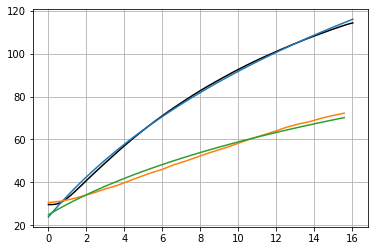

In [155]:
pop1,pcov1 = curve_fit(test,x1,y1)
pop2,pcov2 = curve_fit(test,x2,y2)

plt.plot(x1,y1,color='k')
plt.plot(x1,test(x1,*pop1))
plt.plot(x2,y2)
plt.plot(x2,test(x2,*pop2))
plt.grid()
print(pop1,'\n',pop2)

In [156]:
a = pop1[0]
c = 8.11522678
L = 2.1/1000
Ti = 30
k = 180
ro = 2770
cp = 875
alpha = k/ro/cp

def TTT(alpha,a,t,c,x,L,Ti):
    return a/2/alpha/(t+c)*x**2-a*L/2/alpha/c*x+Ti

t = np.linspace(0,16)
print(TTT(alpha,a,t,c,L,L,Ti))

[30.         29.9880553  29.97700024 29.966739   29.95718904 29.94827888
 29.93994631 29.93213693 29.92480296 29.91790228 29.91139759 29.90525576
 29.89944724 29.89394562 29.8887272  29.88377067 29.87905679 29.87456817
 29.87028904 29.86620506 29.8623032  29.85857152 29.85499914 29.85157606
 29.84829312 29.84514189 29.84211459 29.83920406 29.83640366 29.83370727
 29.83110919 29.82860414 29.82618722 29.82385385 29.82159977 29.81942102
 29.81731387 29.81527486 29.81330073 29.81138843 29.80953511 29.80773807
 29.8059948  29.80430291 29.80266016 29.80106445 29.79951378 29.79800627
 29.79654015 29.79511373]


In [157]:
newX1 = interp1d(x1,y1)
newX2 = interp1d(x2,y2)
x11 = np.linspace(x1[0],x1[-1])
y11 = newX1(x11)
x22 = np.linspace(x2[0],x2[-1])
y22 = newX2(x22)


In [158]:
def d3fun(xt,a,b,c,d,e):
    x,t = xt
    return a*np.log(t+b)+c + d*x+e
dx = [0,.0021]
x = []
t = []
T = []

for i in dx:
    for u in y22:
        x.append(i)

y = [x11,x22]
z = np.array([y11,y22])
for i in y:
    for u in i:
        t.append(u)
for i in z:
    for u in i:
        T.append(u)
print(len(x),len(t),len(T))


pop3,pcov3 = curve_fit(d3fun,[x,t],T)

100 100 100


C:\Users\JoshWhitehea_5801ztl\AppData\Local\Temp\ipykernel_22356\2082657598.py:3: RuntimeWarning: invalid value encountered in log
  return a*np.log(t+b)+c + d*x+e


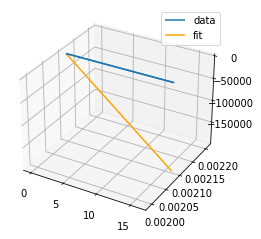

In [162]:
time,dist = np.meshgrid(x11,dx)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_wireframe(time,dist,z,label='data')
ax.plot_wireframe(time,dist,d3fun([time,dist],*pop3),color='orange',label='fit')
ax.legend()
plt.show()

0.9228141564075593
41.69180158275626 -87.87901686265059


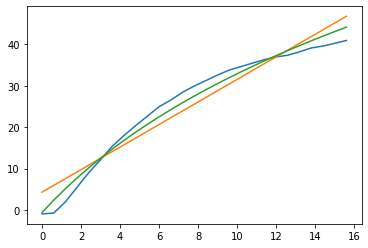

In [160]:
# xTherm,yTherm = interp1d(x1,y1)

newTherm = interp1d(x1,y1)
newCoup = interp1d(x2,y2)

diff = newTherm(x2) - newCoup(x2)
# diff /= diff[-1]
a,b = np.polyfit(x2,diff,1)
popt,pcov = curve_fit(test,x2,diff)
plt.plot(x2,diff)
plt.plot(x2,a*x2+b)
plt.plot(x2,test(x2,*popt))
print(r2(diff,a*x2+b))
;

print(*popt)

In [161]:
from scipy.integrate import odeint
k = 180
dx = 2.1/1000
ro = 2770
cp = 875
Tinf = 30
h = 10
a,b,c = popt
alpha = k/ro/cp

def ode(T,t):
    f = a*np.log(t+c)+b
    dTdt = (f*(k/dx+h)-T*h+Tinf*h)/ro/cp/dx 
    return dTdt

T0 = 30
t = np.linspace(0,2)

T = odeint(ode,T0,t)

plt.plot(t,T)
plt.grid()


ValueError: not enough values to unpack (expected 3, got 2)